In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import jax
from jax import random
from jax import numpy as jnp

from flax.training import train_state
import optax

from npf.jax.models import CNP, NP, AttnCNP
from npf.jax.data import GPSampler, RBFKernel

from tqdm.auto import trange

In [3]:
@jax.jit
def train_step(state, rngs, x_ctx, y_ctx, x_tar, y_tar, mask_ctx, mask_tar, **kwargs):
    def loss_fn(params):
        loss = model.apply(
            params,
            x_ctx=x_ctx,
            y_ctx=y_ctx,
            x_tar=x_tar,
            y_tar=y_tar,
            mask_ctx=mask_ctx,
            mask_tar=mask_tar,
            rngs=rngs,
            method=model.loss,
            **kwargs,
        )
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [4]:
@jax.jit
def eval_step(state, rngs, x_ctx, y_ctx, x_tar, y_tar, mask_ctx, mask_tar, **kwargs):
    loss = model.apply(
        state.params,
        x_ctx=x_ctx,
        y_ctx=y_ctx,
        x_tar=x_tar,
        y_tar=y_tar,
        mask_ctx=mask_ctx,
        mask_tar=mask_tar,
        rngs=rngs,
        method=model.loss,
        **kwargs,
    )
    return loss

In [5]:
x_ctx    = jnp.ones((1, 3, 1))
y_ctx    = jnp.ones((1, 3, 1))
x_tar    = jnp.ones((1, 4, 1))
y_tar    = jnp.ones((1, 4, 1))
mask_ctx = jnp.ones((1, 3))
mask_tar = jnp.ones((1, 4))

model = NP(y_dim=1)
sampler = GPSampler(RBFKernel())

key = random.PRNGKey(0)
key, params_init_key, sample_init_key = random.split(key, 3)

params = model.init(dict(
    params=params_init_key,
    sample=sample_init_key,
), x_ctx, y_ctx, x_tar, mask_ctx, mask_tar)

tx = optax.adam(learning_rate=3e-4)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [6]:
kwargs = dict(
    # loss_type="vi",
    # num_latents=10,
)

num_steps = 10000

for i in trange(1, num_steps + 1):
    key, model_key, data_key = random.split(key, 3)
    batch = sampler.sample(data_key, batch_size=256)
    state, loss = train_step(
        state,
        dict(sample=model_key),
        x_ctx=batch.x_ctx,
        y_ctx=batch.y_ctx,
        x_tar=batch.x,
        y_tar=batch.y,
        mask_ctx=batch.mask_ctx,
        mask_tar=batch.mask,
    )

    if i % 100 == 0:
        loss_ctx = eval_step(
            state,
            dict(sample=model_key),
            x_ctx=batch.x_ctx,
            y_ctx=batch.y_ctx,
            x_tar=batch.x_ctx,
            y_tar=batch.y_ctx,
            mask_ctx=batch.mask_ctx,
            mask_tar=batch.mask_ctx,
        )
        loss_tar = eval_step(
            state,
            dict(sample=model_key),
            x_ctx=batch.x_ctx,
            y_ctx=batch.y_ctx,
            x_tar=batch.x_tar,
            y_tar=batch.y_tar,
            mask_ctx=batch.mask_ctx,
            mask_tar=batch.mask_tar,
        )

        print(f"Step {i}/{num_steps}  CTX Loss: {loss_ctx:7.4f}  TAR Loss: {loss_tar:7.4f}  Loss: {loss:7.4f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 100/10000  CTX Loss:  0.4575  TAR Loss:  0.5079  Loss:  0.4608
Step 200/10000  CTX Loss:  0.6205  TAR Loss:  0.6330  Loss:  0.6223
Step 300/10000  CTX Loss:  0.5027  TAR Loss:  0.5988  Loss:  0.5546
Step 400/10000  CTX Loss:  0.5098  TAR Loss:  0.5714  Loss:  0.5210
Step 500/10000  CTX Loss:  0.4977  TAR Loss:  0.5565  Loss:  0.5120
Step 600/10000  CTX Loss:  0.5062  TAR Loss:  0.5729  Loss:  0.5418
Step 700/10000  CTX Loss:  0.4642  TAR Loss:  0.5464  Loss:  0.4906
Step 800/10000  CTX Loss:  0.3254  TAR Loss:  0.6175  Loss:  0.5669
Step 900/10000  CTX Loss:  0.3837  TAR Loss:  0.5068  Loss:  0.3890
Step 1000/10000  CTX Loss:  0.4029  TAR Loss:  0.5025  Loss:  0.4000
Step 1100/10000  CTX Loss:  0.3936  TAR Loss:  0.4541  Loss:  0.4000
Step 1200/10000  CTX Loss:  0.2718  TAR Loss:  0.4942  Loss:  0.3874
Step 1300/10000  CTX Loss:  0.3898  TAR Loss:  0.4758  Loss:  0.4147
Step 1400/10000  CTX Loss:  0.3597  TAR Loss:  0.4519  Loss:  0.3846
Step 1500/10000  CTX Loss:  0.3095  TAR Los

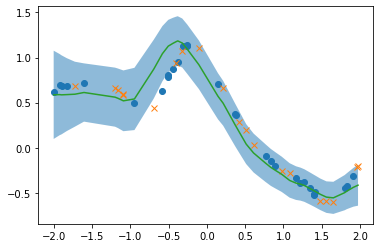

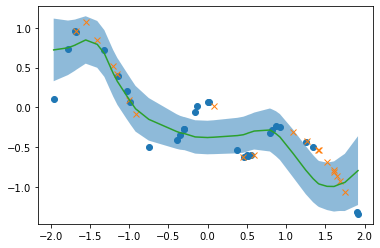

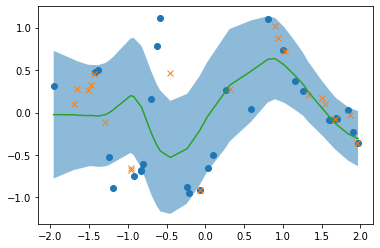

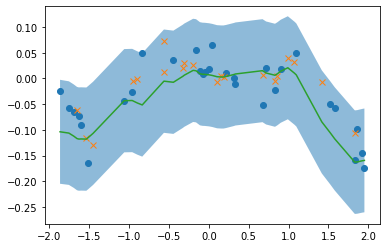

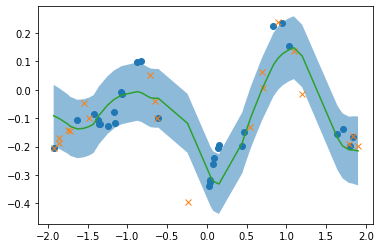

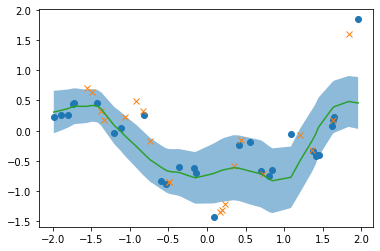

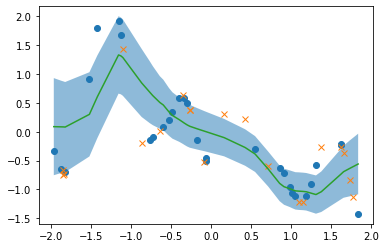

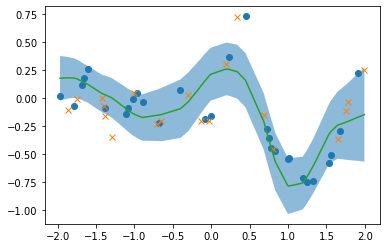

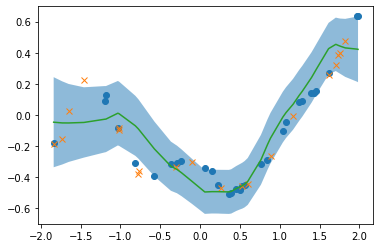

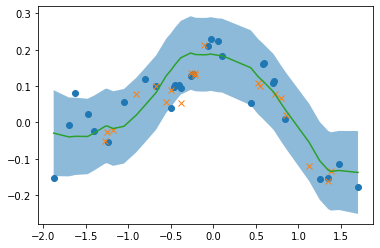

In [8]:
import matplotlib.pyplot as plt

for i in range(10):
    model_key, data_key = random.split(random.PRNGKey(i), 2)
    batch = sampler.sample(data_key, batch_size=5, num_ctx=30, num_tar=20)
    mu, sigma = model.apply(state.params, batch.x_ctx, batch.y_ctx, batch.x, batch.mask_ctx, batch.mask, rngs=dict(sample=model_key))
    mu, sigma = mu.squeeze(axis=1), sigma.squeeze(axis=1)

    idx     = [d for d in jnp.argsort(batch.x[0, :, 0])     if batch.mask[0, d] > 0]
    idx_ctx = [d for d in jnp.argsort(batch.x_ctx[0, :, 0]) if batch.mask_ctx[0, d] > 0]
    idx_tar = [d for d in jnp.argsort(batch.x_tar[0, :, 0]) if batch.mask_tar[0, d] > 0]

    plt.figure()
    plt.plot(batch.x_ctx[0, idx_ctx, 0], batch.y_ctx[0, idx_ctx, 0], 'o')
    plt.plot(batch.x_tar[0, idx_tar, 0], batch.y_tar[0, idx_tar, 0], 'x')
    plt.plot(batch.x[0, idx, 0], mu[0, idx, 0], '-')
    plt.fill_between(batch.x[0, idx, 0], mu[0, idx, 0] - sigma[0, idx, 0], mu[0, idx, 0] + sigma[0, idx, 0], alpha=0.5)
    plt.plot()